# Семинар 2: Семантическая сегментация

## Вступление
Продолжаем работать с изображениями! Разберём задачу сегментации. 

### План семинара
1. Изучаем сегментацию при помощи U-Net на датасете Carvana
2. Изучаем метрики детекции
3. Детектируем объекты на изображениях при помощи YOLO

## 1. Изучаем сегментацию при помощи U-Net на датасете Carvana

### Скачиваем данные, ставим пакеты

In [1]:
!wget https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip
!wget https://www.dropbox.com/s/k886cusbuc1afnq/imagenet-mini.zip
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt  # классы имаджнета

!unzip -q CARVANA.zip -d CARVANA
!unzip -q imagenet-mini.zip

!rm -rf ./train/.DS_Store
!rm -rf ./train_masks/.DS_Store
!rm -rf CARVANA.zip
!rm -rf imagenet-mini.zip

!pip install colour -q

--2025-04-21 09:06:46--  https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip
Распознаётся www.dropbox.com (www.dropbox.com)… 162.125.70.18
Подключение к www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://www.dropbox.com/scl/fi/30c6e8n7m10hbpd2uhv76/CARVANA.zip?rlkey=1wcqbfpj1l5lpz1uq2a7jqcfh [переход]
--2025-04-21 09:06:46--  https://www.dropbox.com/scl/fi/30c6e8n7m10hbpd2uhv76/CARVANA.zip?rlkey=1wcqbfpj1l5lpz1uq2a7jqcfh
Повторное использование соединения с www.dropbox.com:443.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://uc54033f919a7b66e18851334fa3.dl.dropboxusercontent.com/cd/0/inline/CoOkLWlXGC6cxJobY7P1hpoREW47fXq9II_DueR4O3FTiaC8Ve7I3-5FZ3cRKRBPHaoGHsdeZpNKvBYlLKizcvQ1GMisOY_275BnWOdd7wCMm8Y_R7dtvmC2fQBYOb0K3S77_ZgOXv3fhOwNpn8ACznJ/file# [переход]
--2025-04-21 09:06:47--  https://uc54033f919a7b66e18851334fa3.dl.dropboxusercontent.com/cd/0/inline/CoOkLWlXGC6cxJobY7P1

In [1]:
import glob
import math
import os
import warnings
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import wandb
from PIL import Image
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import transforms

warnings.filterwarnings("ignore")

### Организуем данные в класс

In [3]:
import albumentations as A
import albumentations.pytorch


class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, mask_path, transforms):
        self.images = glob.glob(os.path.join(image_path, "*.jpg"))
        self.image_path = image_path
        self.mask_path = mask_path
        self.transforms = transforms

    def __getitem__(self, idx):
        img = np.array(Image.open(self.images[idx]).convert("RGB"))
        mask = np.array(
            Image.open(
                os.path.join(
                    self.mask_path,
                    os.path.basename(self.images[idx]).replace(".jpg", "_mask.gif"),
                )
            )
        )
        mask[mask == 255.0] = 1.0
        augmentations = self.transforms(image=img, mask=mask)
        image = augmentations["image"]
        mask = augmentations["mask"]
        mask = torch.unsqueeze(mask, 0)
        mask = mask.type(torch.float32)
        return image, mask

    def __len__(self):
        return len(self.images)

In [5]:
data = SegmentationDataset(
    image_path="CARVANA/train",
    mask_path="CARVANA/train_masks",
    transforms=A.Compose(
        [A.Resize(height=256, width=256), A.pytorch.transforms.ToTensorV2()]
    ),
)

train_size = 0.9
train_len = math.floor(len(data) * train_size)
val_len = len(data) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=3
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=3
)

### Посмотрим на примеры данных

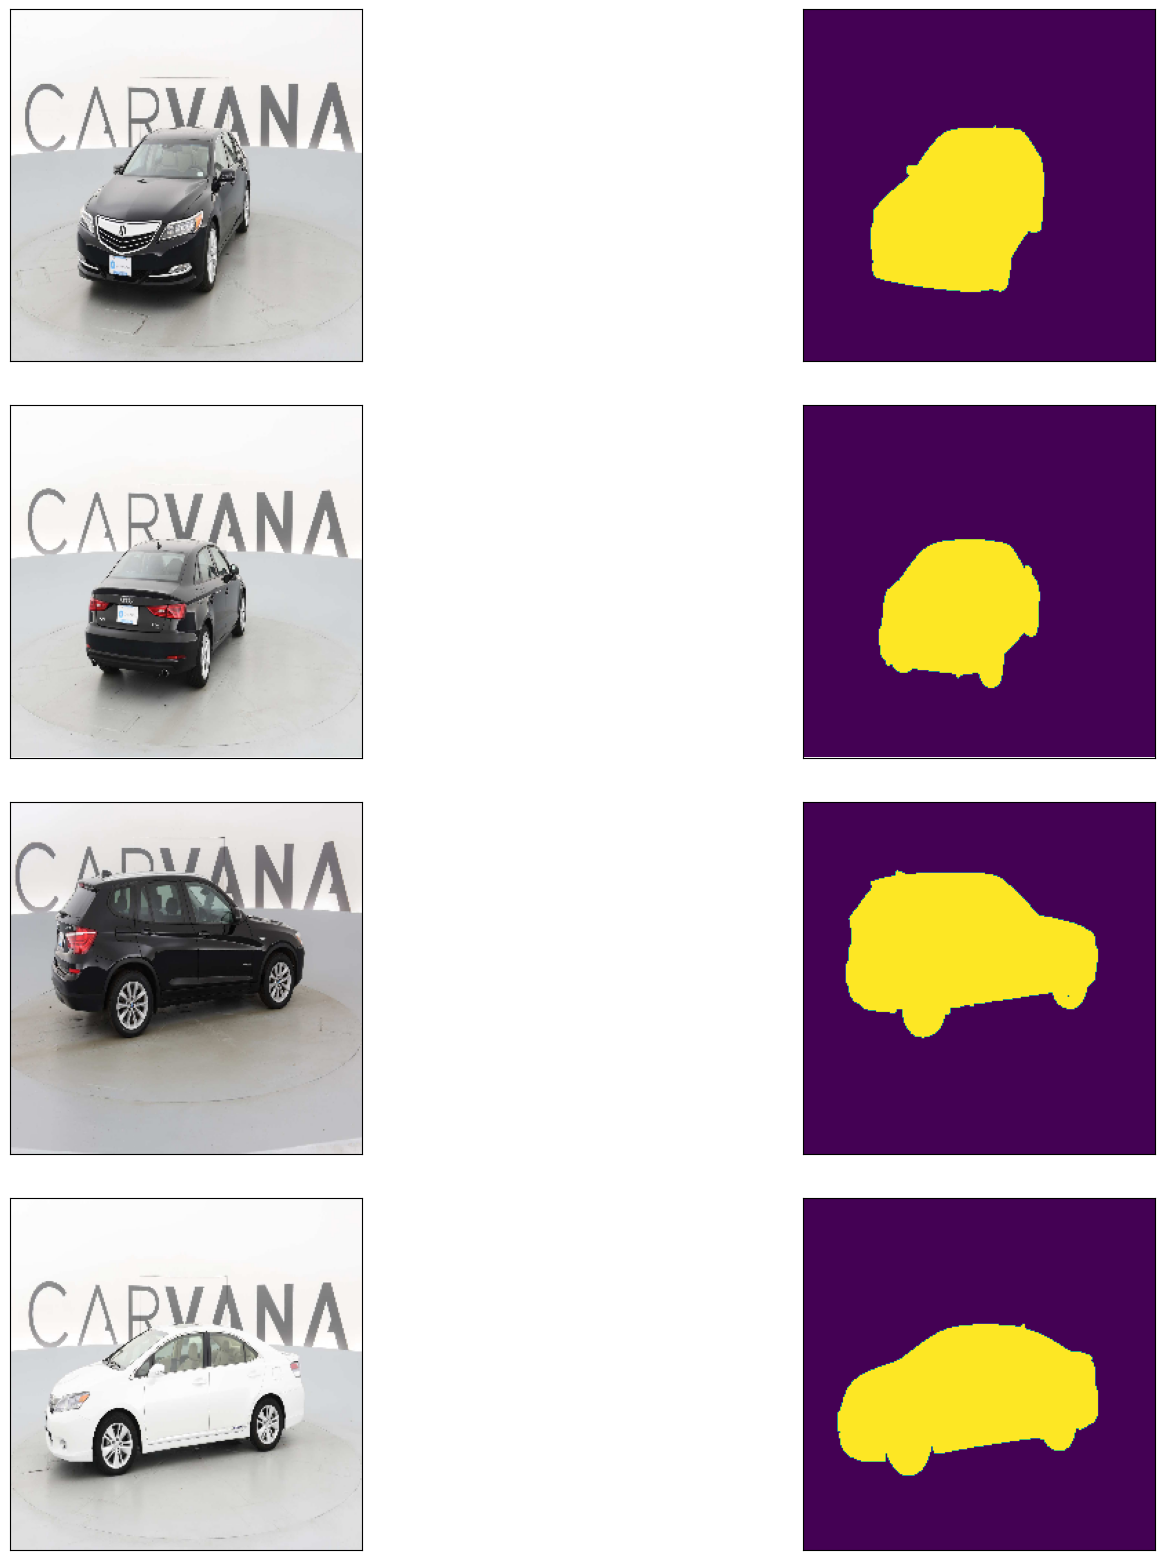

In [6]:
def im_show(img_list: List[Tuple[str, str]]) -> None:
    """
    Plots images with correspinding segmentation mask

    :param img_list: list of paths to images
    """
    to_PIL = transforms.ToPILImage()
    if len(img_list) > 9:
        raise Exception("len(img_list) must be smaller than 10")

    fig, axes = plt.subplots(len(img_list), 2, figsize=(16, 16))
    fig.tight_layout()

    for (idx, sample) in enumerate(img_list):
        a = axes[idx][0].imshow(np.array(to_PIL(sample[0])))
        b = axes[idx][1].imshow(np.array(to_PIL(sample[1])))
        for ax in axes[idx]:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()


img_list = []
for i in range(4):
    img, label = train_dataset[np.random.randint(0, 100)]
    img_list.append((img, label))

im_show(img_list)

### Имплементируем U-Net
#### Архитектура

Дополните недостающий код так, чтобы получилась архитектура [U-net сети](https://arxiv.org/pdf/1505.04597.pdf). Обратите внимание, что при проходе "вниз" количество каналов каждого блока __увеличивается в два раза__. Ситуация с проходом "вверх" противоположна, количество каналов __уменьшается в два раза__. Так же, начинаем мы __не с 64 каналов__, как на схеме ниже, __а с 32 каналов__.

При проходе вниз в нашей реализации предлагается __дойти до 128 каналов__, чтобы сэкономить время обучения, в оригинальной статье было до 1024 (2 блока, вместо 4х). В целом, при отличии количества каналов от указанных выше чисел, модель все равно будет работать, но для удобства проведения семинара лучше всем договориться об одних числах.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png">

Подсказка: каждый блок по пути "вниз" представляет из себя двойную свертку с батч нормом и активацией (при создании `Relu` слоя не забывайте `inplace=True`).

#### ConvTranspose2d

Также мы познакомимся с вами с операцией **nn.ConvTranspose2d**.

**Зачем она?**
Если операция свертки "сворачивает" (convolution) изображение, то, грубо говоря, эта операция обратная - "разворачивает" (deconvolution). Однако важно понимать, что тут нет вычисления значения, обратного свертке, поэтому не совсем верно называть это deconvolution. В модели U-net мы сворачиваем картинку, а затем будем разворачивать, поэтому без данного способа нам не обойтись.

**Как работает?**
Принимает на вход такие же параметры как Conv2d. Подробнее можно почитать в [объяснении со stackoverflow](https://stackoverflow.com/questions/69782823/understanding-the-pytorch-implementation-of-conv2dtranspose).

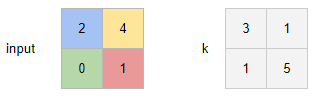

Примеры ниже показывают частные случаи и выходы после данной операции.

**stride=1, padding=0: output is 3x3**
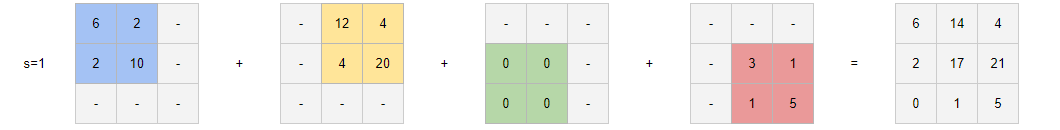

**stride=1, padding=1: output is 1x1**
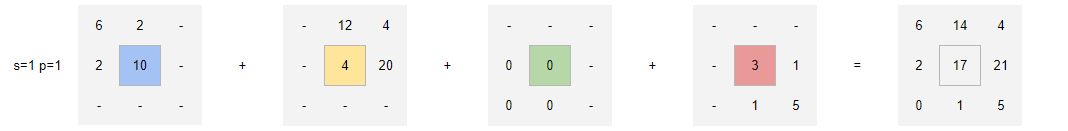

**stride=2, padding=0: output is 4x4**
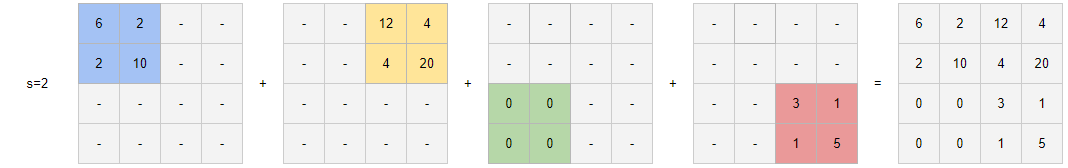

**stride=2, padding=1: output is 2x2**
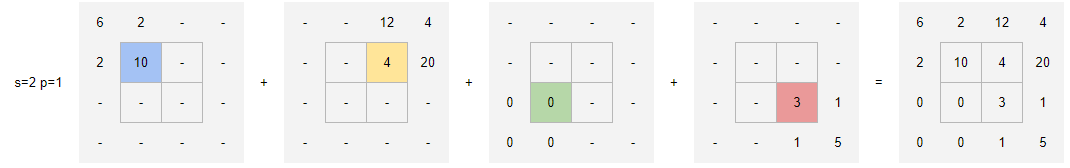

In [7]:
class ConvBlock(pl.LightningModule):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(pl.LightningModule):
    def __init__(
        self,
        in_channels: int = 3,
        out_channels: int = 1,
        features: List[int] = [32, 64, 128],
        learning_rate: float = 1.5e-3,
    ):
        super().__init__()
        self.learning_rate = learning_rate
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)  # Phase change
        for feature in features:
            self.down.append(ConvBlock(in_channels=in_channels, out_channels=feature))
            in_channels = feature
        for feature in reversed(features):
            self.up.append(
                nn.ConvTranspose2d(
                    in_channels=feature * 2,
                    out_channels=feature,
                    kernel_size=2,
                    stride=2,
                )
            )
            self.up.append(
                ConvBlock(
                    in_channels=feature * 2, out_channels=feature
                )  # x gets concat to 2xchannel
            )
        self.bottleneck = ConvBlock(
            in_channels=features[-1], out_channels=features[-1] * 2
        )
        self.final_conv = nn.Conv2d(
            in_channels=features[0], out_channels=out_channels, kernel_size=1
        )
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.learning_rate, weight_decay=0.3
        )

        self.val_num_correct = 0
        self.val_num_pixels = 0
        self.val_dice_score = 0
        self.num_correct = 0
        self.num_pixels = 0
        self.dice_score = 0

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.training_step_dice = []
        self.validation_step_dice = []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        skip_connections = []  # storage for skip connections
        for down in self.down:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # reverse list
        for idx in range(0, len(self.up), 2):
            x = self.up[idx](x)
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = transforms.functional.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat(
                (skip_connection, x), dim=1
            )  # Concat along channels dimensions (b, c, h, w)
            x = self.up[idx + 1](concat_skip)
        return self.final_conv(x)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, batch: torch.Tensor, batch_idx) -> Dict[str, torch.Tensor]:
        x, y = batch
        pred = self(x.float())
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        self.num_correct += (pred == y).sum()
        self.num_pixels += torch.numel(pred)
        self.training_step_dice.append((2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8))
        self.log("train_loss", loss, prog_bar=True)
        self.training_step_outputs.append(loss)
        return {"loss": loss}

    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.training_step_outputs).mean()
        train_acc = float(f"{(self.num_correct/self.num_pixels)*100:.2f}")
        self.log("train_acc", train_acc, prog_bar=True)
        dice_score = torch.stack(self.training_step_dice).mean()
        self.log("train_dice_score", dice_score, prog_bar=True)
        self.num_correct, self.num_pixels, self.dice_score = 0, 0, 0
        self.training_step_outputs.clear()
        self.training_step_dice.clear()

    def validation_step(
        self, batch: torch.Tensor, batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        x, y = batch
        pred = self(x.float())
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        self.val_num_correct += (pred == y).sum()
        self.val_num_pixels += torch.numel(pred)
        self.validation_step_dice.append((2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8))
        self.log("val_loss", loss, prog_bar=True)
        self.validation_step_outputs.append(loss)
        return {"loss": loss}

    def on_validation_epoch_end(self):
        epoch_average = torch.stack(self.validation_step_outputs).mean()
        val_acc = float(f"{(self.val_num_correct / self.val_num_pixels) * 100:.2f}")
        self.log("val_acc", val_acc, prog_bar=True)
        dice_score = torch.stack(self.validation_step_dice).mean()
        self.log("val_dice_score", dice_score, prog_bar=True)
        self.val_num_correct, self.val_num_pixels, self.val_dice_score = 0, 0, 0
        self.validation_step_outputs.clear()
        self.validation_step_dice.clear()

In [8]:
pl.utilities.model_summary.summarize(UNET(), -1)

   | Name              | Type              | Params
---------------------------------------------------------
0  | down              | ModuleList        | 287 K 
1  | down.0            | ConvBlock         | 10.2 K
2  | down.0.conv       | Sequential        | 10.2 K
3  | down.0.conv.0     | Conv2d            | 864   
4  | down.0.conv.1     | BatchNorm2d       | 64    
5  | down.0.conv.2     | ReLU              | 0     
6  | down.0.conv.3     | Conv2d            | 9.2 K 
7  | down.0.conv.4     | BatchNorm2d       | 64    
8  | down.0.conv.5     | ReLU              | 0     
9  | down.1            | ConvBlock         | 55.6 K
10 | down.1.conv       | Sequential        | 55.6 K
11 | down.1.conv.0     | Conv2d            | 18.4 K
12 | down.1.conv.1     | BatchNorm2d       | 128   
13 | down.1.conv.2     | ReLU              | 0     
14 | down.1.conv.3     | Conv2d            | 36.9 K
15 | down.1.conv.4     | BatchNorm2d       | 128   
16 | down.1.conv.5     | ReLU              | 0     
17 | d

In [ ]:
torch.cuda.empty_cache()
model = UNET()

trainer = pl.Trainer(
    max_epochs=2,
    accelerator="mps",
    devices=1)

trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/andrew/courses/MIPT_CV/lesson_2/lightning_logs

  | Name       | Type              | Params
-------------------------------------------------
0 | down       | ModuleList        | 287 K 
1 | up         | ModuleList        | 753 K 
2 | pool       | MaxPool2d         | 0     
3 | bottleneck | ConvBlock         | 885 K 
4 | final_conv | Conv2d            | 33    
5 | loss_fn    | BCEWithLogitsLoss | 0     
-------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.708     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/mbopc_unet/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/mbopc_unet/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'SegmentationDataset' on <module '__main__' (built-in)>


### Посмотрим на результаты

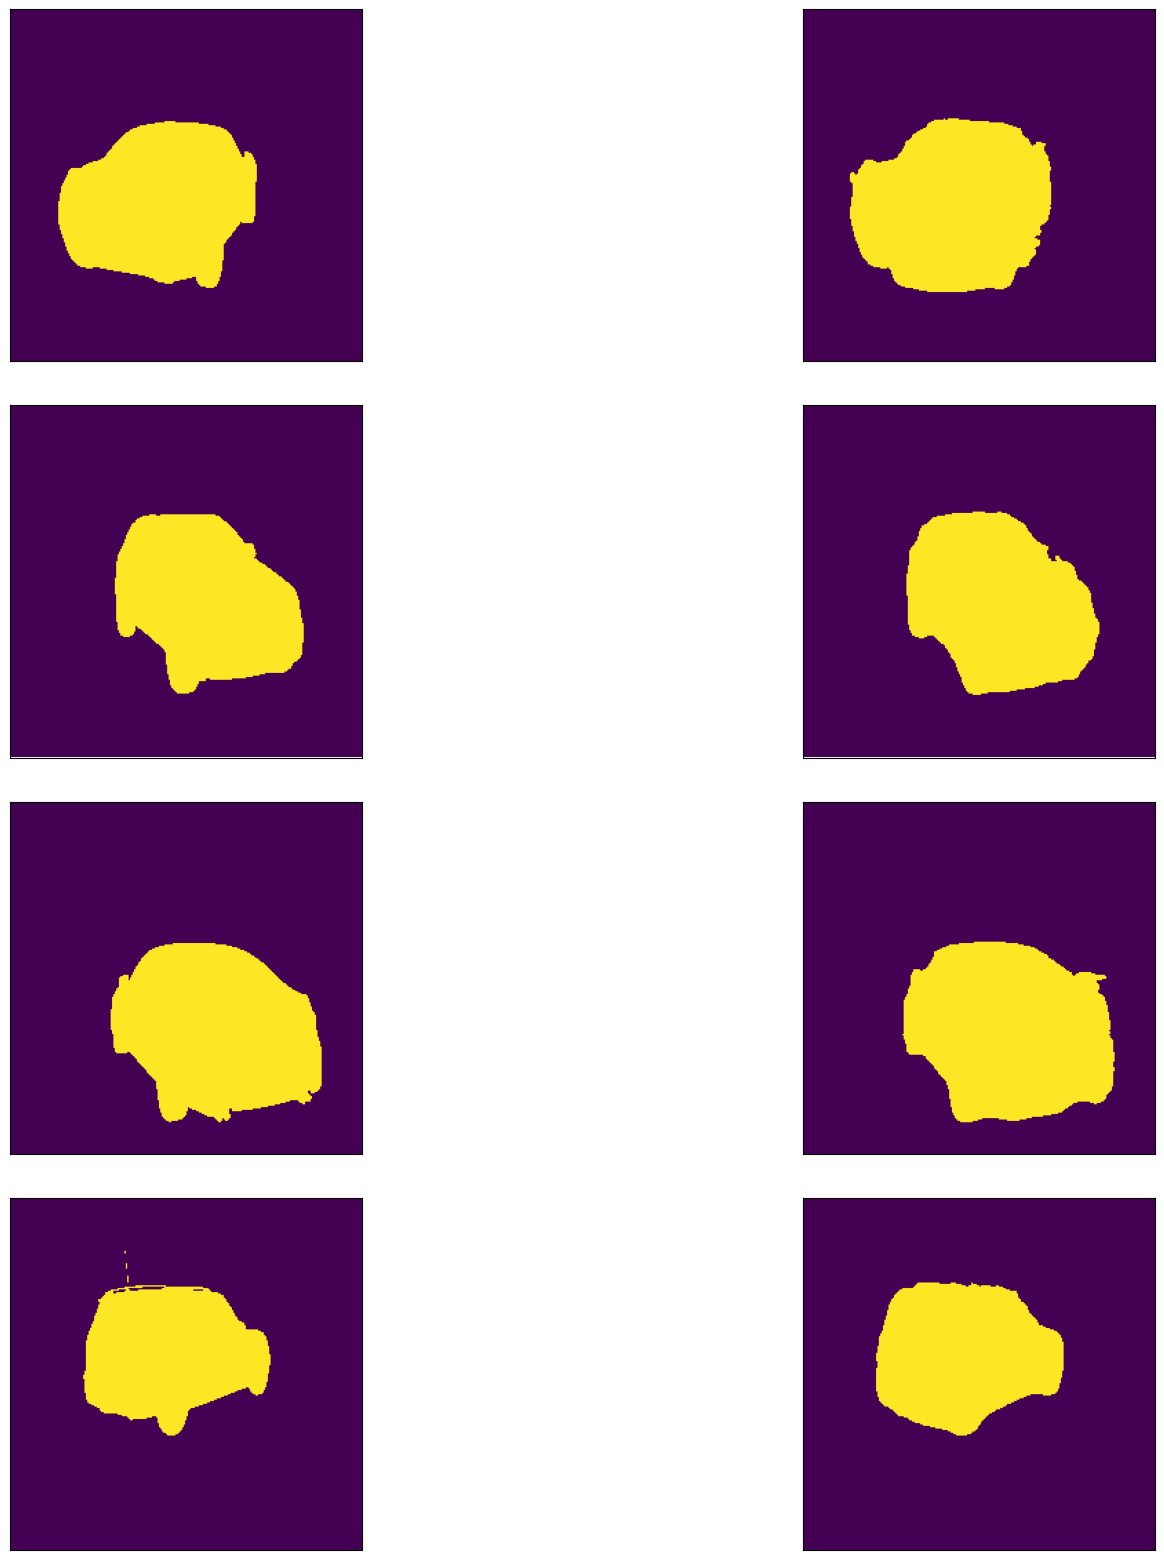

In [12]:
def mask_to_image(mask: np.ndarray) -> np.ndarray:
    if mask.ndim == 2:
        return np.array((mask * 255).astype(np.uint8))
    elif mask.ndim == 3:
        return np.array(
            (np.argmax(mask, axis=0) * 255 / mask.shape[0]).astype(np.uint8)
        )


def predict_img(
    net: nn.Module, img: torch.Tensor, device: str, out_threshold: float = 0.5
) -> np.ndarray:
    net.eval()
    net.to(device)

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        probs = torch.sigmoid(output)
        full_mask = probs.cpu().squeeze()

        return (full_mask > out_threshold).numpy()


img_list = []
for i in range(4):
    # img_base, img = train_dataset[np.random.randint(0, 100)]
    img_base, img = val_dataset[np.random.randint(0, 100)]
    mask = predict_img(model, img_base, device="cuda:0")
    result = mask_to_image(mask)
    img_list.append((img, result))
im_show(img_list)

Пример инференса в случае если хотим подгрузить существующие веса:

In [ ]:
## в случае если хотим подгрузить веса для инференса
# lit_model = UNET.load_from_checkpoint("courses/MIPT_CV/lesson_2/carvana_segmentation.ckpt")

## # disable randomness, dropout, etc...
# lit_model.eval()